In [1]:
import netket as nk
from numpy.lib.function_base import append
from itertools import permutations, combinations
from netket.vqs.mc import get_local_kernel_arguments, get_local_kernel
import time
import matplotlib.pyplot as plt
import json
import numpy as np
from numpy.linalg import eig
# from flax.core.frozen_dict import FrozenDict
import flax
from netket.optimizer.qgt import QGTJacobianPyTree


from typing import Callable, Tuple
from functools import partial

import jax
from jax import numpy as jnp

from netket.stats import statistics as mpi_statistics, mean as mpi_mean, Stats
from netket.utils.types import PyTree
from netket.operator.spin import sigmax, sigmay,sigmaz

import matplotlib.pyplot as plt
from tqdm import tqdm
################################################################
################################################################
################################################################
###############ED는 sparse matrix가지고 한다 !!!###################
from scipy.sparse.linalg import eigsh
################################################################
################################################################
################################################################
import os
import pandas as pd
import seaborn as sns


from alpha_mcmc import alpha_mcmc
from calculate_variance import calculate_variance


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# Define a 1d chain
L = 10
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
#g.translation_group
#g.point_group
#g.rotation_group
#g.space_group

hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
Gamma = np.random.uniform(-1,1,10)

# ha = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
#          + sigmay(hi,i)*sigmay(hi,(i+1)%L)
#          + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
#            for i in range(L)])

# ha = ha + sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])
ha = sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])


In [3]:
leng = np.shape(hi.all_states())[0]
# E, vec = eigsh(ha.to_sparse(), 1000)

In [4]:
leng

252

In [5]:
E, vec = eigsh(ha.to_sparse(),k = leng-2)

In [6]:
E

array([-5.55589067, -5.13085524, -4.94807268, -4.91719372, -4.34347515,
       -4.33655169, -4.16069259, -4.12981363, -3.76671286, -3.73565715,
       -3.7047782 , -3.54917161, -3.52199564, -3.32919505, -3.22467492,
       -3.19436165, -3.1464125 , -3.12413617, -3.11553354, -3.04189237,
       -3.01157909, -3.01101341, -2.98070014, -2.97933277, -2.94135361,
       -2.91047465, -2.72137706, -2.6904981 , -2.61685693, -2.58654365,
       -2.58597797, -2.5556647 , -2.55429733, -2.53489151, -2.50771554,
       -2.43037138, -2.40319541, -2.40005811, -2.37288214, -2.37151478,
       -2.34063582, -2.10985607, -2.00533594, -1.97502267, -1.96505268,
       -1.93399697, -1.92707352, -1.90311801, -1.89619456, -1.86053255,
       -1.83021927, -1.82947684, -1.82255339, -1.79916357, -1.79859788,
       -1.79224011, -1.79167443, -1.76828461, -1.76136116, -1.75999379,
       -1.72033546, -1.61581533, -1.58550205, -1.54001724, -1.43549711,
       -1.40518384, -1.35723468, -1.32635573, -1.32247599, -1.29

In [52]:
Et

1.7269102707299506

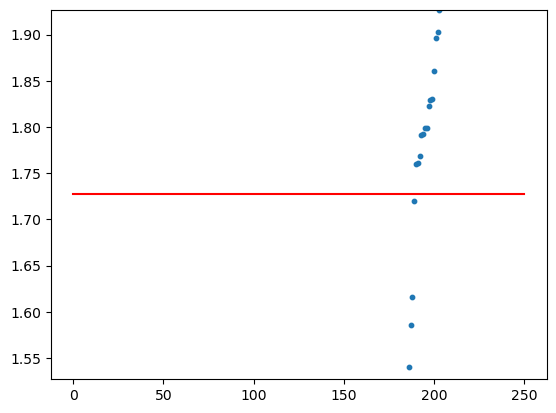

In [51]:
LOW = 1
HIG = 2
Et = np.random.uniform(low=LOW, high=HIG, size=None)
plt.scatter(np.arange(len(E)),np.sort(E),s=10)
plt.ylim([Et-0.2,Et+0.2])
plt.plot([0,len(E)],[Et,Et],'r')

In [8]:
# def dimension_depen(n_steps, learning_rate, bond_dimen, hamil, target_E):
def dimension_depen(n_steps, learning_rate, bond_dimen):


  model = nk.models.MPSPeriodic(hilbert=hi, graph=g, bond_dim=bond_dimen)
  sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

  vs = nk.vqs.FullSumState(hi, model)

  # Optimizer
  op = nk.optimizer.Sgd(learning_rate=learning_rate)
  # Stochastic Reconfiguration
  sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)

  Target_Ha = ha - Et
    
  gs = nk.VMC(
      hamiltonian=Target_Ha@Target_Ha,
      optimizer=op,
      preconditioner=sr,
      variational_state=vs)

  start = time.time()
  gs.run(n_steps, out='MPS')
  end = time.time()

  return vs

In [10]:
vs01 = dimension_depen(10000, 0.01, 1)

100%|█| 10000/10000 [00:17<00:00, 578.21it/s, Energy=6.303e-03+4.091e-22j ± 0.00


In [15]:
print(vs01.expect(ha).mean.real)
print(vs01.expect((ha-Et)@(ha-Et)).mean.real)
print(calculate_variance(ha,vs01))

1.7611739212890098
0.006302774967177012
0.0062658727934397085


In [ ]:
calculate_variance(ha,vs01)

In [35]:
lis = [1,2,3,4,5,6,7,8,9,10,20,30,40]
En = []
En_Et_squred = []
Varian = []
states = []

In [36]:
[vs,vs]

[FullSumState(
   hilbert = Spin(s=1/2, total_sz=0, N=10),
   n_parameters = 50000),
 FullSumState(
   hilbert = Spin(s=1/2, total_sz=0, N=10),
   n_parameters = 50000)]

In [37]:
for i in lis:
    vs = dimension_depen(10000, 0.01, i)
    states.append(vs)
    En.append(vs.expect(ha).mean.real)
    En_Et_squred.append(vs.expect((ha-Et)@(ha-Et)).mean.real)
    Varian.append(calculate_variance(ha,vs))

100%|█| 10000/10000 [00:17<00:00, 569.13it/s, Energy=5.747e-03-6.063e-21j ± 0.00
100%|█| 10000/10000 [00:48<00:00, 204.22it/s, Energy=2.402e-03-3.512e-21j ± 0.00
100%|█| 10000/10000 [01:17<00:00, 128.55it/s, Energy=6.859e-03-7.584e-21j ± 0.00
100%|█| 10000/10000 [01:23<00:00, 120.34it/s, Energy=8.268e-03-5.234e-21j ± 0.00
100%|█| 10000/10000 [02:40<00:00, 62.21it/s, Energy=7.141e-03-1.056e-20j ± 0.000
100%|█| 10000/10000 [03:21<00:00, 49.75it/s, Energy=6.390e-03-2.113e-20j ± 0.000
100%|█| 10000/10000 [05:10<00:00, 32.24it/s, Energy=7.902e-03-8.231e-21j ± 0.000
100%|█| 10000/10000 [03:51<00:00, 43.16it/s, Energy=5.827e-03+1.877e-20j ± 0.000
100%|█| 10000/10000 [06:06<00:00, 27.26it/s, Energy=7.542e-03-4.403e-21j ± 0.000
100%|█| 10000/10000 [07:17<00:00, 22.86it/s, Energy=7.095e-03-3.503e-20j ± 0.000
100%|█| 10000/10000 [19:34<00:00,  8.52it/s, Energy=7.413e-03-2.763e-21j ± 0.000
100%|█| 10000/10000 [50:50<00:00,  3.28it/s, Energy=7.711e-03-2.354e-21j ± 0.000
100%|█| 10000/10000 [1:37:20

In [55]:
log_E_Et_squred = np.log10(En_Et_squred)
log_variance = np.log10(Varian)

In [49]:
En

[Array(1.75674818, dtype=float64),
 Array(1.79258526, dtype=float64),
 Array(1.78757111, dtype=float64),
 Array(1.78266641, dtype=float64),
 Array(1.78577634, dtype=float64),
 Array(1.78650697, dtype=float64),
 Array(1.78031987, dtype=float64),
 Array(1.7882477, dtype=float64),
 Array(1.78496641, dtype=float64),
 Array(1.78659234, dtype=float64),
 Array(1.78925759, dtype=float64),
 Array(1.78782102, dtype=float64),
 Array(1.78417965, dtype=float64)]

In [42]:
En_Et_squred

[Array(0.00574656, dtype=float64),
 Array(0.00240172, dtype=float64),
 Array(0.00685863, dtype=float64),
 Array(0.00826717, dtype=float64),
 Array(0.00714041, dtype=float64),
 Array(0.00638885, dtype=float64),
 Array(0.00790126, dtype=float64),
 Array(0.00582692, dtype=float64),
 Array(0.00754156, dtype=float64),
 Array(0.00709465, dtype=float64),
 Array(0.00741297, dtype=float64),
 Array(0.00771047, dtype=float64),
 Array(0.00708105, dtype=float64)]

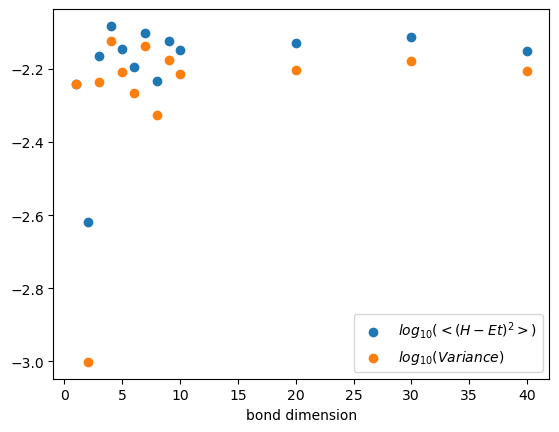

In [57]:
plt.scatter(lis, log_E_Et_squred, label=r'$log_{10}(<(H-Et)^2>)$')
plt.scatter(lis, log_variance, label=r'$log_{10}(Variance)$')
plt.xlabel('bond dimension')
plt.legend()

In [30]:
Varian

[Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64),
 Array(0.00626587, dtype=float64)]

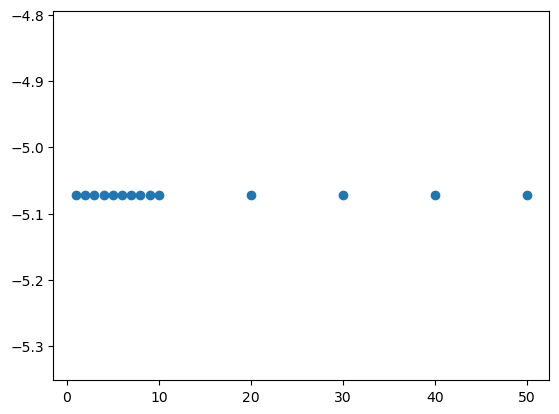

In [28]:
plt.scatter(lis, log_variance)

In [ ]:
# vs1 = dimension_depen(10000, 0.01, 10, hamil=ha, target_E=Et)
vs1 = dimension_depen(10000, 0.01, 10)
# vs2 = dimension_depen(3000, 0.01, 20)
# vs3 = dimension_depen(3000, 0.01, 30)
# vs4 = dimension_depen(3000, 0.01, 40)


In [ ]:
vs2 = dimension_depen(10000, 0.01, 20)

In [ ]:
print(vs1.expect(ha))
print(vs1.expect((ha-Et)@(ha-Et)))
print(calculate_variance(ha,vs1))

In [ ]:
print(vs2.expect(ha))
print(vs2.expect((ha-Et)@(ha-Et)))
print(calculate_variance(ha,vs2))

In [ ]:
print(vs3.expect((ha-Et)@(ha-Et)))
print(calculate_variance(ha,vs3))

In [ ]:
print(vs4.expect((ha-Et)@(ha-Et)))
print(calculate_variance(ha,vs4))